## Topic Modeling with Gensim Library

Topic Modeling is a technique to extract the hidden topics from large volumes of text. **Latent Dirichlet Allocation(LDA)** is a popular algorithm for topic modeling which can be implemented in the Python with the help of Gensim and traditional Sklearn packages. I'll be using gensim package for extract topics for this notebook

In [2]:
#Importing req libraries
import pandas as pd
import numpy as np

#plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#To Ignore Warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#Setting theme style
plt.style.use('fivethirtyeight')

C:\Users\ragul\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#NLTK for basic NLP techniques
import nltk 

#For lemmatization
import spacy

Now ,we have imported libraries which can be used for data preprocessing.We should import modules that can be used for topic modeling and viz purposes

In [4]:
#Genism
import gensim

#To create tokens and their ID's
import gensim
from gensim.corpora import dictionary
from gensim.utils import simple_preprocess
from gensim.models import coherencemodel


#PLotting for Topics
import pyLDAvis
from pyLDAvis import gensim

LDA considers each *documents as a collection of topics ,and each Topic as a collection of Keywords*

When i say Topic,It means ,Topic is nothing but a **collection of Keywords**.Just by Looking at Keywords we could identify the topic even for a large amount of Documents

The followings are key factors to obtain Good Quality of Topics:


   `
   1.Text processing Quality
   2.Choice of model
   3.chice of #of Topics choosen 
   4.Tuning Parmeters`

#### Let's import the famous newsgroup file for this modelling


In [5]:
#since it's a json i used pandas json method to read the file
doc = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

#let's take a glance
doc.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


#### Let's do some Basic EDA

In [6]:
#Length of the docs
print(f"Shape of the docs : {doc.shape}")

Shape of the docs : (11314, 3)


In [7]:
print(f"No of Documents        : {doc.shape[0]}")
print(f"No of Features/columns  : {doc.shape[1]}")
print(f"\nNo of topics {doc.target.nunique()}")

No of Documents        : 11314
No of Features/columns  : 3

No of topics 20


In [8]:
#Distribution of topics
doc.target_names.value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
sci.space                   593
comp.windows.x              593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: target_names, dtype: int64

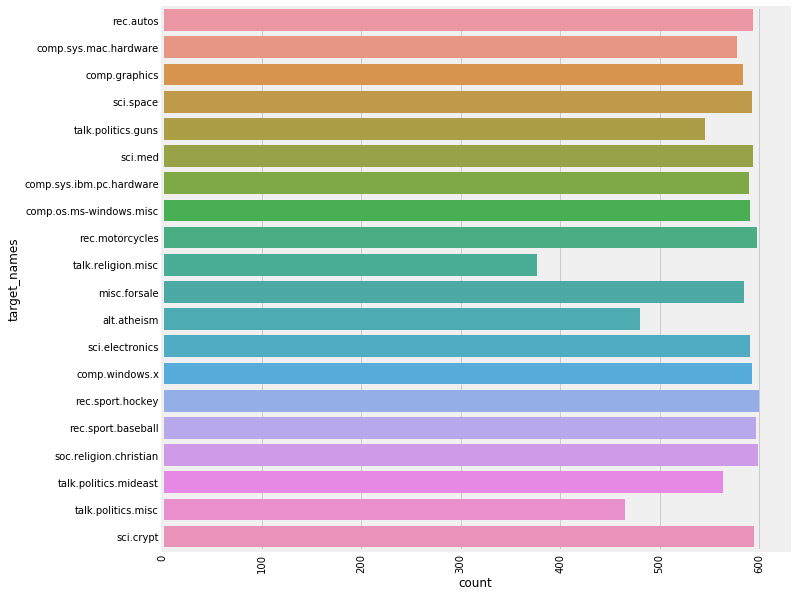

In [9]:
#Visualise above methods
#Frequency of the target names
plt.figure(figsize=(10,10))
sns.countplot(y=doc.target_names)

#if you wanna rotate xlabels use below code unless you need it
#rotate xlabels to 45degree
plt.xticks(rotation='vertical');

In [10]:
#lets see what topics assigened to which numbers
for no,topic in sorted(zip(doc.target.unique(),doc.target_names.unique())):
    print(f"NO {no:{4}} Topic {topic}")

NO    0 Topic alt.atheism
NO    1 Topic comp.graphics
NO    2 Topic comp.os.ms-windows.misc
NO    3 Topic comp.sys.ibm.pc.hardware
NO    4 Topic comp.sys.mac.hardware
NO    5 Topic comp.windows.x
NO    6 Topic misc.forsale
NO    7 Topic rec.autos
NO    8 Topic rec.motorcycles
NO    9 Topic rec.sport.baseball
NO   10 Topic rec.sport.hockey
NO   11 Topic sci.crypt
NO   12 Topic sci.electronics
NO   13 Topic sci.med
NO   14 Topic sci.space
NO   15 Topic soc.religion.christian
NO   16 Topic talk.politics.guns
NO   17 Topic talk.politics.mideast
NO   18 Topic talk.politics.misc
NO   19 Topic talk.religion.misc


### Cleansing and Improving Quality of the text

we'll do one of the important steps that can be used all of the NLP tasks which improves the quality of the documents.
Those tasks such**Text cleansing tasks such as Removing Noise,Removing stopwords and punctuations,contracting words into original forms,eliminating rare words etc..**

Let's get rid of them using Regex module

In [12]:
#import re package
import re

#convert it into list
data = doc.content.tolist()

#removing emails
data = [re.sub('\S*@S*\s?',' ',sent) for sent in data]

# removing new line characters
data = [re.sub('\s+',' ',sent) for sent in data]

#removing single Quotes
data = [re.sub("\'",' ',sent) for sent in data]

#Ensuring it worked
data[1]

<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \s
<ipython-input-12-1bf9694b34ce>:8: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@S*\s?',' ',sent) for sent in data]
<ipython-input-12-1bf9694b34ce>:11: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+',' ',sent) for sent in data]


'From: carson.u.washington.edu (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for SI clock reports Keywords: SI,acceleration,clock,upgrade Article-I.D.: shelley.1qvfo9INNc3s Organization: University of Washington Lines: 11 NNTP-Posting-Host: carson.u.washington.edu A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll. Please send a brief message detailing your experiences with the procedure. Top speed attained, CPU rated speed, add on cards and adapters, heat sinks, hour of usage per day, floppy disk functionality with 800 and 1.4 m floppies are especially requested. I will be summarizing in the next two days, so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll. Thanks. Guy Kuo u.washington.edu> '

Even though removing emails and extra spaces from text it looks still messy.Let's further analyse and cleanse the docs.

##### Tokenise and cleanse the docs

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether

In [13]:
#defining function to tokenise sentences
def tokens(data):
    for sent in data:
        yield simple_preprocess(sent,deacc=True) #Deacc true removes the punctuation marks
        
data = list(tokens(data))     

All the steps that i have implemented using only gensim module ,we could leverage other NLP libaries for above steps. We could have used NLTK or Spcay for that. I'll show in the below steps

In [14]:
#Lets see the results for above methods
data[0]

['from',
 'wam',
 'umd',
 'edu',
 'where',
 'my',
 'thing',
 'subject',
 'what',
 'car',
 'is',
 'this',
 'nntp',
 'posting',
 'host',
 'rac',
 'wam',
 'umd',
 'edu',
 'organization',
 'university',
 'of',
 'maryland',
 'college',
 'park',
 'lines',
 'was',
 'wondering',
 'if',
 'anyone',
 'out',
 'there',
 'could',
 'enlighten',
 'me',
 'on',
 'this',
 'car',
 'saw',
 'the',
 'other',
 'day',
 'it',
 'was',
 'door',
 'sports',
 'car',
 'looked',
 'to',
 'be',
 'from',
 'the',
 'late',
 'early',
 'it',
 'was',
 'called',
 'bricklin',
 'the',
 'doors',
 'were',
 'really',
 'small',
 'in',
 'addition',
 'the',
 'front',
 'bumper',
 'was',
 'separate',
 'from',
 'the',
 'rest',
 'of',
 'the',
 'body',
 'this',
 'is',
 'all',
 'know',
 'if',
 'anyone',
 'can',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'of',
 'production',
 'where',
 'this',
 'car',
 'is',
 'made',
 'history',
 'or',
 'whatever',
 'info',
 'you',
 'have',
 'on',
 'this',
 'funky',
 'looking',
 'car',
 'p

### Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

we use gensim `phrases` function to create bigram and trigram models. The two important parameters are `min_count` and `threshold`

In [15]:
from gensim.models.phrases import Phraser

In [16]:
#Bigram and trigram model

import gensim

bigram = gensim.models.Phrases(data,min_count=3,threshold=100) #Min count to remove rare occuring words
trigram = gensim.models.Phrases(bigram[data],min_count=5,threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

#see an example
trigram_mod[bigram_mod[data[3]]]

['from',
 'amber',
 'joe',
 'green',
 'subject',
 're',
 'weitek',
 'organization',
 'harris',
 'computer',
 'systems',
 'division',
 'lines',
 'distribution_world',
 'nntp_posting_host',
 'amber_ssd',
 'csd_harris',
 'com',
 'newsreader_tin_version_pl',
 'robert_kyanko_rjck_uucp',
 'wrote',
 'iastate',
 'edu',
 'writes',
 'in',
 'article',
 'class',
 'iastate',
 'edu',
 'anyone',
 'know',
 'about',
 'the',
 'weitek',
 'graphics',
 'chip',
 'as',
 'far',
 'as',
 'the',
 'low_level',
 'stuff',
 'goes',
 'it',
 'looks',
 'pretty',
 'nice',
 'it',
 'got',
 'this',
 'quadrilateral',
 'fill',
 'command',
 'that',
 'requires',
 'just',
 'the',
 'four',
 'points',
 'do',
 'you',
 'have',
 'weitek',
 'address',
 'phone',
 'number',
 'like',
 'to',
 'get',
 'some',
 'information',
 'about',
 'this',
 'chip',
 'joe',
 'green',
 'harris',
 'corporation',
 'csd_harris',
 'com',
 'computer',
 'systems',
 'division',
 'the',
 'only',
 'thing',
 'that',
 'really',
 'scares',
 'me',
 'is',
 'person',


### Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.


In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

Let’s call the function

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data)

# Form Bigrams
data_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'car', 'nntp_posting', 'host_rac', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


### Create a Dictionary and Corpus needed for LDA Model

The two main inputs to the LDA topic model are the `dictionary(id2word)` and the corpus. Let’s create them

In [20]:
from gensim import corpora
#create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#DTM (Document Term Matrix)
corpus =[id2word.doc2bow(text) for text in data_lemmatized]

#see an Example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, **word id 1 occurs twice and so on and so forth**

In [21]:
#lets see word id 0 represents what word
id2word[0]

'addition'

In [518]:
#Lets build a better version for readability
for id,occ in corpus[:1][0]:
    print(f"{id2word[id]:{13}} occurs {occ} times")

addition      occurs 1 times
body          occurs 1 times
bricklin      occurs 1 times
bring         occurs 1 times
call          occurs 1 times
car           occurs 5 times
could         occurs 1 times
day           occurs 1 times
door          occurs 2 times
early         occurs 1 times
engine        occurs 1 times
enlighten     occurs 1 times
funky         occurs 1 times
history       occurs 1 times
host_rac      occurs 1 times
info          occurs 1 times
know          occurs 1 times
late          occurs 1 times
lerxst        occurs 1 times
line          occurs 1 times
look          occurs 2 times
mail          occurs 1 times
make          occurs 1 times
model         occurs 1 times
name          occurs 1 times
neighborhood  occurs 1 times
nntp_posting  occurs 1 times
park          occurs 1 times
production    occurs 1 times
really        occurs 1 times
rest          occurs 1 times
see           occurs 1 times
separate      occurs 1 times
small         occurs 1 times
sport         

In [24]:
#Readable format
[(id2word[id],occ) for id,occ in corpus[:1][0]]

[('addition', 1),
 ('body', 1),
 ('bricklin', 1),
 ('bring', 1),
 ('call', 1),
 ('car', 5),
 ('could', 1),
 ('day', 1),
 ('door', 2),
 ('early', 1),
 ('engine', 1),
 ('enlighten', 1),
 ('funky', 1),
 ('history', 1),
 ('host_rac', 1),
 ('info', 1),
 ('know', 1),
 ('late', 1),
 ('lerxst', 1),
 ('line', 1),
 ('look', 2),
 ('mail', 1),
 ('make', 1),
 ('model', 1),
 ('name', 1),
 ('neighborhood', 1),
 ('nntp_posting', 1),
 ('park', 1),
 ('production', 1),
 ('really', 1),
 ('rest', 1),
 ('see', 1),
 ('separate', 1),
 ('small', 1),
 ('sport', 1),
 ('tellme', 1),
 ('thank', 1),
 ('thing', 1),
 ('wonder', 1),
 ('year', 1)]

## Building the Model

We have everything required to build a model.Now we choose the important parameters for that model

In [533]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [531]:
#Print top 10 words for each topics
doc_lda = lda_model[corpus]
lda_model.print_topics()

[(0,
  '0.040*"go" + 0.022*"get" + 0.018*"time" + 0.018*"say" + 0.017*"take" + 0.017*"right" + 0.015*"people" + 0.014*"year" + 0.014*"come" + 0.013*"back"'),
 (1,
  '0.034*"would" + 0.021*"know" + 0.020*"make" + 0.020*"think" + 0.016*"may" + 0.015*"say" + 0.015*"good" + 0.014*"see" + 0.014*"people" + 0.012*"thing"'),
 (2,
  '0.079*"patient" + 0.039*"motif" + 0.038*"treatment" + 0.035*"doctor" + 0.030*"waste" + 0.027*"minor" + 0.024*"scientific" + 0.022*"improve" + 0.022*"medical" + 0.022*"energy"'),
 (3,
  '0.055*"university" + 0.053*"family" + 0.053*"cpu" + 0.041*"controller" + 0.035*"room" + 0.035*"load" + 0.034*"telnet" + 0.032*"rational" + 0.030*"catch" + 0.027*"screw"'),
 (4,
  '0.146*"faith" + 0.102*"child" + 0.046*"revelation" + 0.045*"moral" + 0.044*"steal" + 0.034*"parent" + 0.033*"animal" + 0.028*"battery" + 0.028*"door" + 0.026*"interpretation"'),
 (5,
  '0.093*"att" + 0.054*"specify" + 0.044*"solid" + 0.032*"rutger" + 0.025*"flyer" + 0.015*"leak" + 0.015*"bolt" + 0.015*"uok

**SO How we interpret from above results?**

Topic 0 represents '0.040*"go" + 0.022*"get" + 0.018*"time" + 0.018*"say" + 0.017*"take" + 0.017*"right" + 0.015*"people" + 0.014*"year" + 0.014*"come" + 0.013*"back"

It means Top 10 words belongs to Topic no 0. And their numbers represent weightage of that word. Looking at the keywords we could infer the what topics are discussed...


### Computing Model Performance
Coherence score will be used to judge a model how good it is. Higher the score the better the model is.

In [532]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word)
lda_coherence = coherence_model_lda.get_coherence()

print(f"Coherence Score {lda_coherence}")

Coherence Score 0.4532084685299435


## VIsualize topic keywords with PyLDA

PyLDAvis package espically designed for the purpose of viualizing keyword in a topic for anyone could understand.


In [28]:
#PLot Topics
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model,corpus=corpus,dictionary=id2word)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.333506 -0.173006       1        1  32.544216
0      0.293290 -0.219390       2        1  17.455469
9      0.280320 -0.065033       3        1  13.123195
8      0.261198  0.130904       4        1   9.396680
10     0.156064  0.178253       5        1   7.545094
18     0.110826  0.180250       6        1   4.031164
11     0.069412  0.180598       7        1   3.302985
19     0.014451  0.094027       8        1   2.385498
14    -0.018594  0.114045       9        1   2.179986
15    -0.132388 -0.015010      10        1   1.371706
12    -0.015623 -0.124302      11        1   1.161104
6     -0.118192 -0.039440      12        1   0.843052
2     -0.135239 -0.009162      13        1   0.805587
3     -0.147032 -0.019252      14        1   0.734897
16    -0.138085 -0.028959      15        1   0.722376
7     -0.134286 -0.067920      16        1   0.652906
4     -0.140261 -0.014739      17        1   0.596232
13    -0.163281 -0.027847      18        1   0.496793
17    -0.170998 -0.031142      19        1   0.493176
5     -0.205089 -0.042877      20        1   0.157892, topic_info=            Term          Freq         Total Category  logprob  loglift
19          line  15471.000000  15471.000000  Default  30.0000  30.0000
196        write  12800.000000  12800.000000  Default  29.0000  29.0000
175          com   9779.000000   9779.000000  Default  28.0000  28.0000
172      article   7831.000000   7831.000000  Default  27.0000  27.0000
39          year   4648.000000   4648.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4986        self      0.027866      1.207945  Topic20 -11.0472   2.6817
6811  distribute      0.027865      1.207907  Topic20 -11.0472   2.6817
5031     playoff      0.027865      1.207950  Topic20 -11.0472   2.6817
3266     condemn      0.027865      1.207890  Topic20 -11.0472   2.6818
3373       slave      0.027865      1.208024  Topic20 -11.0472   2.6817

[843 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
845      20  0.898807  aardvark_ucs
464      17  0.988762      absolute
40       18  0.927359  acceleration
2362     12  0.981073     accompany
2009      9  0.991087      accurate
...     ...       ...           ...
196       5  0.924900         write
444       1  0.998941         wrong
39        2  0.600897          year
39        3  0.234507          year
39       11  0.164585          year

[1084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 10, 9, 11, 19, 12, 20, 15, 16, 13, 7, 3, 4, 17, 8, 5, 14, 18, 6])

**A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.**

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
We haven't successfully built a good looking topic model. Our model did a worst job at predicting topics, Its coherence score is too low(45%)


In [30]:
for no,words in lda_model.show_topics(num_topics=20,num_words=15,formatted=False):
    for word in words:
        print(f"Topic No {no} Keywords {word[0]}")

Topic No 0 Keywords go
Topic No 0 Keywords get
Topic No 0 Keywords time
Topic No 0 Keywords say
Topic No 0 Keywords take
Topic No 0 Keywords right
Topic No 0 Keywords people
Topic No 0 Keywords year
Topic No 0 Keywords come
Topic No 0 Keywords back
Topic No 0 Keywords day
Topic No 0 Keywords start
Topic No 0 Keywords happen
Topic No 0 Keywords first
Topic No 0 Keywords last
Topic No 1 Keywords would
Topic No 1 Keywords know
Topic No 1 Keywords make
Topic No 1 Keywords think
Topic No 1 Keywords may
Topic No 1 Keywords say
Topic No 1 Keywords good
Topic No 1 Keywords see
Topic No 1 Keywords people
Topic No 1 Keywords thing
Topic No 1 Keywords could
Topic No 1 Keywords well
Topic No 1 Keywords way
Topic No 1 Keywords much
Topic No 1 Keywords point
Topic No 2 Keywords patient
Topic No 2 Keywords motif
Topic No 2 Keywords treatment
Topic No 2 Keywords doctor
Topic No 2 Keywords waste
Topic No 2 Keywords minor
Topic No 2 Keywords scientific
Topic No 2 Keywords improve
Topic No 2 Keywords med

## Assigning Dominant Topic for Each Documents

In order to find topic for a document,we must find the topic number that has the highest percentage contribution in that document.

In [113]:
#Getting topmost topic and thier probabilty for each documents
topic_df = pd.concat([doc.content,pd.Series(lda_model.get_document_topics(corpus))],axis=1)

In [122]:
#Defining function to extract dominant topic for each document
def dominant_topic(data):
    
    topic = list()
    probab = list()
    
    for i in data: #Loop through each topic and their proabability
        
        topic.append(i[0]) #Taking topic
        probab.append(i[1])#Taking probability
    df= pd.DataFrame(probab,index=topic) #It replaces the df index with topin number #Craeting a df using above extracted topic and proabability
    topic =  df.idxmax()[0] #Idxmax gives us a index position of highest probability but we placed topic Number in that place. SO we'll get topic number
    return topic

#Lets see if it works
topic_df['Dominant_Topic'] = topic_df[0].apply(dominant_topic)

#Take a glance at df
topic_df.head()

,content,0,Dominant_Topic
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,"[(0, 0.17607856), (1, 0.2519259), (4, 0.086009...",1
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,"[(0, 0.0991835), (1, 0.14887998), (3, 0.017158...",9
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,"[(0, 0.2014221), (1, 0.40216273), (8, 0.188995...",1
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,"[(0, 0.08881559), (1, 0.36922526), (8, 0.11659...",1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,"[(0, 0.098978505), (1, 0.30599305), (8, 0.2950...",1


In [295]:
#Breaking it down how above code works 
topic = list()
probab = list()
    
for i in topic_df[0][2]: #Loop through for document no 2 topics
        
    topic.append(i[0]) #Taking topic
    probab.append(i[1])#Taking probability
df= pd.DataFrame(probab,index=topic) #It replaces the df index with topin number #Craeting a df using above extracted topic and proabability
topic =  df.idxmax()[0] 
topic

1

I'll won't be using above code to extract topics and probability. I showed my method of extracting topics. I'll be using below code to extract topics and other related features. I took code from <a href="https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels">this</a> article.

In [297]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2519,"would, know, make, think, may, say, good, see,...","[from, wam, umd, edu, where, my, thing, subjec..."
1,1,9.0,0.2443,"number, also, include, information, order, sou...","[from, carson, washington, edu, guy, kuo, subj..."
2,2,1.0,0.4022,"would, know, make, think, may, say, good, see,...","[from, ec, ecn, purdue, edu, thomas, willis, s..."
3,3,1.0,0.3692,"would, know, make, think, may, say, good, see,...","[from, amber, joe, green, subject, re, weitek,..."
4,4,1.0,0.3060,"would, know, make, think, may, say, good, see,...","[from, head, cfa, harvard, edu, jonathan, mcdo..."
5,5,1.0,0.4165,"would, know, make, think, may, say, good, see,...","[from, vttoulu, tko, vtt, fi, foxvog, douglas,..."
6,6,8.0,0.2621,"use, thank, system, file, program, mail, need,...","[from, quads, uchicago, edu, brian, manning, d..."
7,7,1.0,0.2790,"would, know, make, think, may, say, good, see,...","[from, dante, nmsu, edu, grubb, subject, re, i..."
8,8,1.0,0.3477,"would, know, make, think, may, say, good, see,...","[from, iscsvax, uni, edu, subject, win, icon, ..."
9,9,8.0,0.2614,"use, thank, system, file, program, mail, need,...","[from, ux, cso, uiuc, edu, stan, kerr, subject..."


Amazing,isn't it?. From this table we could understand it easily and interpret results.

## Finding Highest probability Document for each Topic


Sometimes keywords just aren't enough to judge topic for a document!!!

In [351]:
#We use pandas groupby method for retrieving highest prob doc for each topic
top_prob = df_dominant_topic.groupby('Dominant_Topic').agg('max')
top_prob = top_prob.iloc[:,1:].reset_index() #Extract only relevant features
top_prob

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6279,"go, get, time, say, take, right, people, year,...","[subject, re, young, catchers, from, strobe, a..."
1,1.0,0.7413,"would, know, make, think, may, say, good, see,...","[zaphod, mps, ohio, state, edu, wupost, uunet,..."
2,7.0,0.3611,"soldier, village, turkish, armenian, civilian,...","[from, zuma, uucp, serdar, argic, subject, to,..."
3,8.0,0.5202,"use, thank, system, file, program, mail, need,...","[to, gatech, edu, distribution, world, from, e..."
4,9.0,0.5776,"number, also, include, information, order, sou...","[subject, wanted, restaurant, equipment, from,..."
5,10.0,0.4485,"line, write, com, article, host, organization,...","[subject, re, who, picks, first, from, mtroyal..."
6,11.0,0.4196,"drive, buy, price, sell, player, sale, chip, s...","[subject, vhs, movie, for, sale, from, hirama,..."
7,12.0,0.3840,"team, game, win, play, year, score, run, last,...","[subject, nhl, summary, parse, results, for, g..."
8,14.0,0.2459,"book, religion, discussion, belief, atheist, s...","[from, ssc, com, mark, zenier, subject, re, tr..."
9,15.0,0.9861,"ax, max, monitor, character, normal, rider, id...","[subject, roman, bmp, part, of, from, salmon, ..."


The tabular shows dominant topics and their highest probability document and related keywords. The `Topic_Prec_Contrib` feature represent probability of topic belongs to a document.

In [345]:
#Distribution of diff topics
pd.Series(df_dominant_topic.Dominant_Topic.value_counts()).to_frame()

,Dominant_Topic
1.0,8700
0.0,1003
8.0,872
9.0,328
10.0,247
18.0,66
11.0,44
12.0,15
19.0,14
7.0,14


In [390]:
#Explore more features
#Counting doc for each document
Doc_counts = df_dominant_topic.Dominant_Topic.value_counts().reset_index()

#Percentage of each topic present in the dataset
Top_perc = df_dominant_topic.Dominant_Topic.value_counts(normalize=True).round(4).reset_index()

#Concat features
merged_df = pd.merge(Doc_counts,Top_perc,on='index')

merged_df.rename(columns={'Dominant_Topic_x':'Topic_Counts','Dominant_Topic_y':'Topic_Prec','index':'Dominant_Topic'},inplace=True)

#Merging required to get desired 
final_df = pd.merge(top_prob,merged_df,on='Dominant_Topic').drop('Text',axis=1)

final_df.sort_values('Topic_Counts',ascending=False)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Topic_Counts,Topic_Prec
1,1.0,0.7413,"would, know, make, think, may, say, good, see,...",8700,0.7690
0,0.0,0.6279,"go, get, time, say, take, right, people, year,...",1003,0.0887
3,8.0,0.5202,"use, thank, system, file, program, mail, need,...",872,0.0771
4,9.0,0.5776,"number, also, include, information, order, sou...",328,0.0290
5,10.0,0.4485,"line, write, com, article, host, organization,...",247,0.0218
10,18.0,0.4714,"key, system, space, technology, public, govern...",66,0.0058
6,11.0,0.4196,"drive, buy, price, sell, player, sale, chip, s...",44,0.0039
7,12.0,0.3840,"team, game, win, play, year, score, run, last,...",15,0.0013
2,7.0,0.3611,"soldier, village, turkish, armenian, civilian,...",14,0.0012
11,19.0,0.3836,"car, power, light, serious, engine, low, hour,...",14,0.0012


### Conclusion

we started with understanding what LDA do and Preprocessed text then feed it into model then it created Topics for us. Eventually we extract insights for each topics such as highest prob doc,keywords,distribution of topics.



## How to make prediction for unseen data

It's a simple process. Before we make predictions, we should pre-process data such as removing noises,lemmatize and tranform it into BOW model just like we did before develop LDA model. Then we can make predictions out of it.

In [510]:
#Proprecessing steps
def text_preprocess(text):

    #removing emails
    data = re.sub('\S*@S*\s?',' ',text)

    # removing new line characters
    #data = [re.sub('\s+',' ',data) ]

    #removing single Quotes
    #data = [re.sub("\'",' ',data) ]
    
       
    data = [token.lemma_ for token in nlp(str(data)) ]
    #data = simple_preprocess(data,deacc=True) 
    
    data = [word for word in data if not word in stop_words]
    data = [word for word in data if word not in '-PRON-']
 
    return data

<>:5: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<ipython-input-510-9abf057567e4>:5: DeprecationWarning: invalid escape sequence \S
  data = re.sub('\S*@S*\s?',' ',text)


In [511]:
proc_text = text_preprocess('I just bought a car and its engine is really not bad. horse power. i will email you the details to ragulshan@gmail.com.car car car car car car car')
proc_text

['buy',
 'car',
 'engine',
 'really',
 'bad',
 '.',
 'horse',
 'power',
 '.',
 'email',
 'detail',
 ' ',
 'gmail.com.car',
 'car',
 'car',
 'car',
 'car',
 'car',
 'car']

In [526]:
def get_topics(text):
    corpus = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus)
    topic = list()
    probab = list()
    
    for i in topics: #Loop through each topic and their proabability
        
        topic.append(i[0]) #Taking topic
        probab.append(i[1])#Taking probability
    df= pd.DataFrame(probab,index=topic) #It replaces the default index with topic number
    topic =  df.idxmax()[0]
    prob = round(df.max()*100,2)[0]
    return f"Given text/article belongs to Topic_No: {topic} and it has proability of {prob} "

#see the magic
get_topics(proc_text)

'Given text/article belongs to Topic_No: 19 and it has proability of 28.13 '

**NOTE:** Our model did a really worst job at predicting topics.We expected 20 topics instead we got less then 15 topics. I got really disappointed, i could improve the performance of that model by adjusting diff parameters of LDA_model.AS per experts, Coherence score can be used for evaluation topic models.